In [6]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch" 

import keras_nlp
import keras
import keras.backend as K
import tensorflow as tf

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

ModuleNotFoundError: No module named 'keras_nlp'

In [ ]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

NameError: name 'tf' is not defined

In [ ]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 3 # Training epochs
    batch_size = 32  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler

In [ ]:
keras.utils.set_random_seed(CFG.seed)

In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
def parse_time_to_seconds(time_str):
    try:
        # 正規表現を使用して日数と時間部分を抽出
        match = re.match(r'(\d+)\s*days?\s*(\d{1,2}):?(\d{2})?:?(\d{2})?', time_str)
        if match:
            days, hours, minutes, seconds = match.groups()
            days = int(days)
            hours = int(hours) if hours else 0
            minutes = int(minutes) if minutes else 0
            seconds = int(seconds) if seconds else 0
            
            total_seconds = days * 86400 + hours * 3600 + minutes * 60 + seconds
            return float(total_seconds)
        else:
            return float(-1)
    except:
      return float(-1)
    
# Load data
df = pd.read_csv('train.csv')  # Read CSV file into a DataFrame

df['timeToReply'] = df['timeToReply'].apply(parse_time_to_seconds)
df['reviewCreatedVersion'].fillna(-1, inplace=True)

reviews = df.review.values
replies = df.replyContent.values
sentences = [reviews[i] + " [SEP] " + replies[i] for i in range(len(reviews))]
sentences = np.array(sentences)
df['score'] = df['score'] + 1

df['full_text'] = sentences

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Train Data: 8,767
# Sample:


/tmp/ipykernel_2965927/2220183424.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviewCreatedVersion'].fillna(-1, inplace=True)


,Unnamed: 0,review,score,thumbsUpCount,reviewCreatedVersion,replyContent,timeToReply,full_text
0,0,Banyak bug nya!!!! Dikit² eror terus,1,0,33.0,"Hello BANK Friend, sorry for the issues you’re...",-1.0,Banyak bug nya!!!! Dikit² eror terus [SEP] Hel...
1,1,Cash deposit menu does not appear Even after u...,3,0,32.0,"Hello, Friend BANK. Kindly upgrade the BANKApp...",-1.0,Cash deposit menu does not appear Even after u...


In [ ]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["score"])

In [ ]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [ ]:
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()
train_df["label"]

5022    [1.0, 0.0, 0.0, 0.0, 0.0]
5770    [1.0, 1.0, 1.0, 1.0, 0.0]
2615    [1.0, 1.0, 1.0, 1.0, 1.0]
1740    [1.0, 1.0, 1.0, 1.0, 1.0]
1562    [1.0, 1.0, 1.0, 1.0, 1.0]
                  ...            
6925    [1.0, 1.0, 1.0, 1.0, 1.0]
3085    [1.0, 1.0, 1.0, 1.0, 1.0]
8002    [1.0, 1.0, 1.0, 1.0, 0.0]
2892    [1.0, 1.0, 1.0, 1.0, 1.0]
2522    [1.0, 1.0, 1.0, 0.0, 0.0]
Name: label, Length: 7013, dtype: object

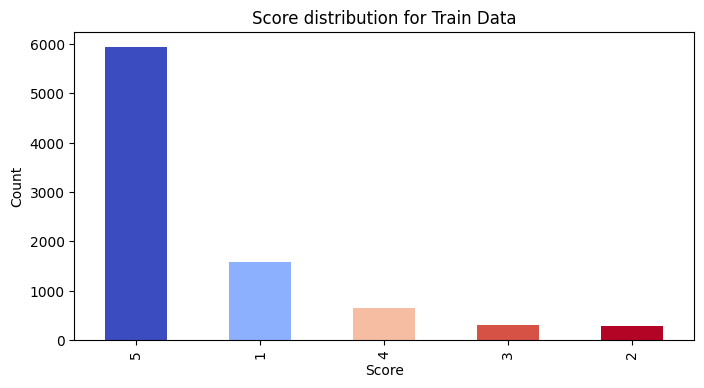

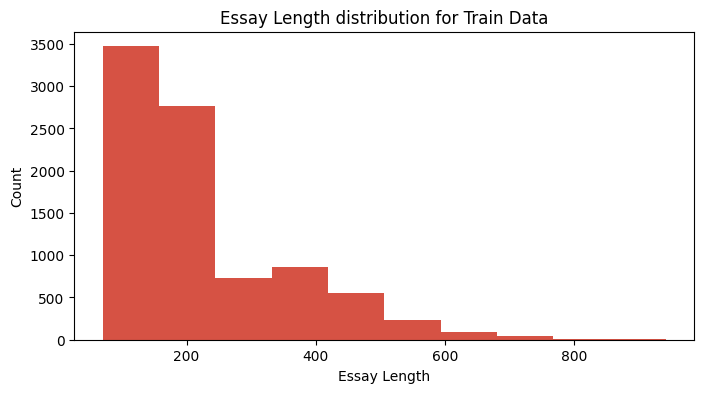

In [ ]:
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.score.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution for Train Data")
plt.show()

# Show distribution of essay length using a bar plot
plt.figure(figsize=(8, 4))
df['essay_length'] = df.full_text.map(len)
df.essay_length.plot.hist(logy=False, color=cmap(0.9))
plt.xlabel("Essay Length")
plt.ylabel("Count")
plt.title("Essay Length distribution for Train Data")
plt.show()

In [ ]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

2024-08-12 23:00:12.108268: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
inp = preprocessor(df.full_text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


token_ids : (512,)
padding_mask : (512,)


In [ ]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

In [ ]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

In [ ]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, drop_remainder=True,
                  shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds

In [ ]:
# Train Data
train_texts = train_df.full_text.tolist()  # Extract training texts
train_labels = np.array(train_df.label.tolist())  # Extract training labels

# Build training dataset
train_ds = build_dataset(
    train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True
)

# Valid Data
valid_texts = valid_df.full_text.tolist()  # Extract validation texts
valid_labels = np.array(valid_df.label.tolist())  # Extract validation labels

# Build validation dataset
valid_ds = build_dataset(
    valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False
)


In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

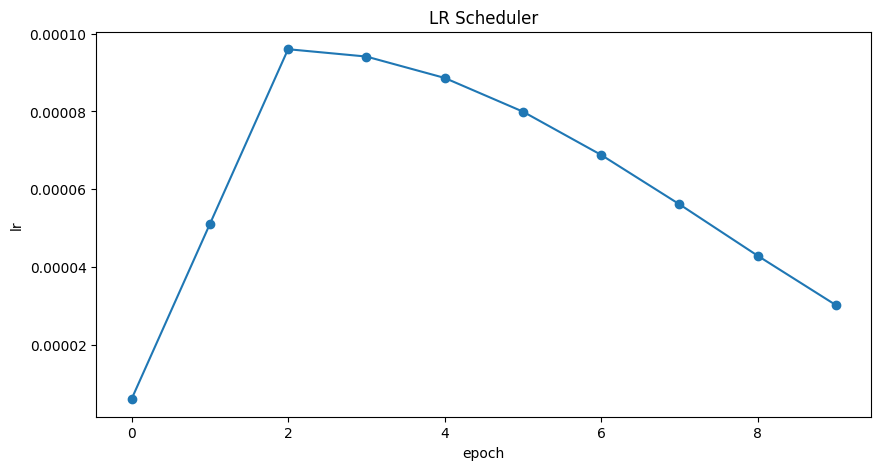

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)


In [ ]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=5, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name="o_sum", initializer="zeros")
        self.e_sum = self.add_weight(name="e_sum", initializer="zeros")

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        y_true = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_true, dtype="int8"), axis=-1) - 1, 6
        )
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(
            keras.ops.sum(
                keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
            )
        )

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)


In [ ]:
# Create a DebertaV3Classifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=5
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)

# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        WeightedKappa()
    ],
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 5)         │ 70,831,877 │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 5)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,831,877 (270.20 MB)

 Trainable params: 70,831,877 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

2024-08-12 23:00:20.739294: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: Cannot get result() since the metric has not yet been built.

In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(model.history.history['val_weighted_kappa'])
best_score = model.history.history['val_weighted_kappa'][best_epoch]
best_loss = model.history.history['val_loss'][best_epoch]

# Print and display best results
print(f'\n{"=" * 17} RESULTS {"=" * 17}')
print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Score : {best_score:.3f}\n>>>> BEST Epoch : {best_epoch}')
print('=' * 50)

In [ ]:
# Load best checkpoint
model.load_weights("best_model.weights.h5")

# Make predictions using the trained model on last validation data
valid_preds = model.predict(valid_ds, verbose=0)

# Format predictions and true answers
pred_scores = np.sum((valid_preds > 0.5).astype(int), axis=-1)
true_scores = valid_df.score.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text = row.full_text
    pred_answer = pred_scores[i]
    true_answer = true_scores[i]
    print(f"❓ Text {i+1}:\n{text[:150]} .... {text[-150:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-" * 90, "\n")


In [ ]:
# # Train Data
test_df = pd.read_csv("test.csv")

test_df['timeToReply'] = test_df['timeToReply'].apply(parse_time_to_seconds)
test_df['reviewCreatedVersion'].fillna(-1, inplace=True)

reviews = test_df.review.values
replies = test_df.replyContent.values
sentences = [reviews[i] + " [SEP] " + replies[i] for i in range(len(reviews))]
sentences = np.array(sentences)

test_df['full_text'] = sentences

test_texts = test_df.full_text.fillna("").tolist()  # Extract training texts

# Build training dataset
test_ds = build_dataset(
    test_texts,
    labels=None,
    batch_size=min(CFG.batch_size, len(test_df)),
    shuffle=False,
    drop_remainder=False,  # include all samples
)


AttributeError: 'DataFrame' object has no attribute 'full_text'

In [ ]:
# Do inference
test_preds = model.predict(test_ds, verbose=1)

# Convert probabilities to class labels
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)